### __CMASS - $p_k$ with $1$ sky-cut__
Comparison between samples generated with the *westcoast* (WC) prior setup or the *eastcoast* (EC) prior setup. Both apply a gaussian BBN-related prior on $\omega_b$.

In [20]:
# Import modules and set up plotting
from python_scripts.support import *
%matplotlib inline
# Latex font style
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Define chain folder
chain_dir = os.path.join(os.getcwd(), 'chains/')

__1. Loading the data__

In [21]:
# First distributions: BOSS + BBN Prior
posterior1 = loadMCSamples(file_root=chain_dir+'cmass_wc_std/posterior', settings={'ignore_rows':0.})
posterior1.name_tag = 'CMASS WC'
prior1 = loadMCSamples(file_root=chain_dir+'cmass_wc_std/prior', settings={'ignore_rows':0.})
prior1.name_tag = 'CMASS WC Prior'
# Get the parameter limits
param_limits1 = pd.read_csv(chain_dir+'cmass_wc_std/param_limits.csv', index_col=0)
# Convert to dictionary
param_limits1 = param_limits1.to_dict()
for key in param_limits1.keys():
    param_limits1[key] = (param_limits1[key][0], param_limits1[key][1])

# Second distributions: BOSS
posterior2 = loadMCSamples(file_root=chain_dir+'cmass_ec_std/posterior', settings={'ignore_rows':0.})
posterior2.name_tag = 'CMASS EC'
prior2 = loadMCSamples(file_root=chain_dir+'cmass_ec_std/prior', settings={'ignore_rows':0.})
prior2.name_tag = 'CMASS EC Prior'
# Get the parameter limits
param_limits2 = pd.read_csv(chain_dir+'cmass_ec_std/param_limits.csv', index_col=0)
# Convert to dictionary
param_limits2 = param_limits2.to_dict()
for key in param_limits2.keys():
    param_limits2[key] = (param_limits2[key][0], param_limits2[key][1])

# Define the cosmological and nuisance parameter names and labels
params1 = posterior1.getParamNames().list()
labels1 = posterior1.getLatex()[0]
params2 = posterior2.getParamNames().list()
labels2 = posterior2.getLatex()[0]
# Exclude A_s to avoid degeneracy with sigma_8
# Exclude Omega_m from the cosmological parameter list to avoid degeneracy with omega_cdm, 
# omega_b and h
params1 = [param for param in params1 if ('A' not in param) and ('Omega' not in param)]
labels1 = [label for label in labels1 if ('A' not in label and ('Omega' not in label))]
params2 = [param for param in params2 if ('A' not in param) and ('Omega' not in param)]
labels2 = [label for label in labels2 if ('A' not in label) and ('Omega' not in label)]
# Define the nuisance parameter names and labels
nuisance_params1 = params1[4:6]
nuisance_labels1 = labels1[4:6]
nuisance_params2 = params2[4:7]
nuisance_labels2 = labels2[4:7]
# Define the cosmological parameter names and labels: the cosmological parameters are the same,
# while each chain has different nuisance parameters 
cosmo_params = [param for param in params1 if param not in nuisance_params1]
cosmo_labels = [label for label in labels1 if label not in nuisance_labels1]

__2. Transforming to logarithmic scale__\
Unfortunately, EFT priors have negative values and so we can not transform these parameters to logarithmic scale.

In [22]:
# Parameters to be transformed to logarithmic scale
params_tolog = [param for param in cosmo_params if (param != 'ln10^{10}A_s')]
# Define the labels based on the index of the parameters to be transformed
labels_tolog = [cosmo_labels[cosmo_params.index(param)] for param in params_tolog]
# Transform these parameters to logarithmic scale
for chain in [posterior1, prior1, posterior2, prior2]:
    log_params, log_labels = log_transform(chain, params_tolog, labels_tolog)

In [23]:
# Since we are going to use log-params, add the nuisance parameters to this list
log_params1 = log_params + nuisance_params1
log_labels1 = log_labels + nuisance_labels1
log_params2 = log_params + nuisance_params2
log_labels2 = log_labels + nuisance_labels2

__3. CPCA decomposition__

N_eff 	= 4.9174

Improvement factor over the prior in E.U.:
 [44.56  6.42  3.04  1.99  1.61  0.84  0.35]


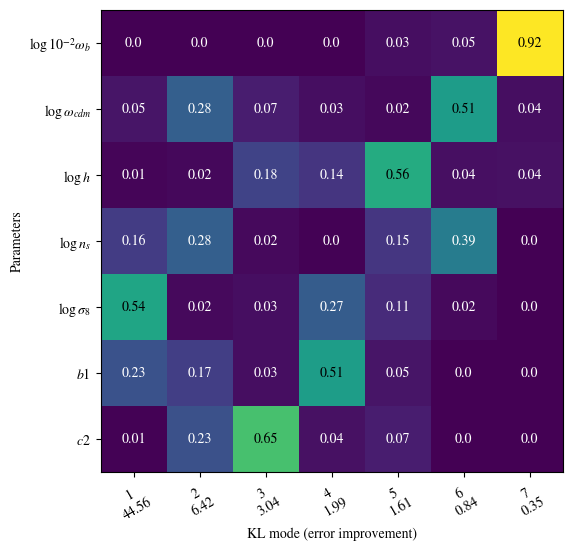

In [24]:
# Plot the fractional CPCA loading matrix on the WC chain
KL_eig1, KL_eigv1, KL_param_names1 = plot_frac_fisher(prior_chain=prior1, posterior_chain=posterior1, 
                                                      params=log_params1, labels=log_labels1,
                                                      norm=True, figsize=6, print_improvement=True,
                                                      savename='fisher_cmass_wc.pdf')

N_eff 	= 4.3512

Improvement factor over the prior:
 [1064.16   21.06    4.7     3.22    2.24    1.59    1.      0.95]
Discarding error units due to negative values.


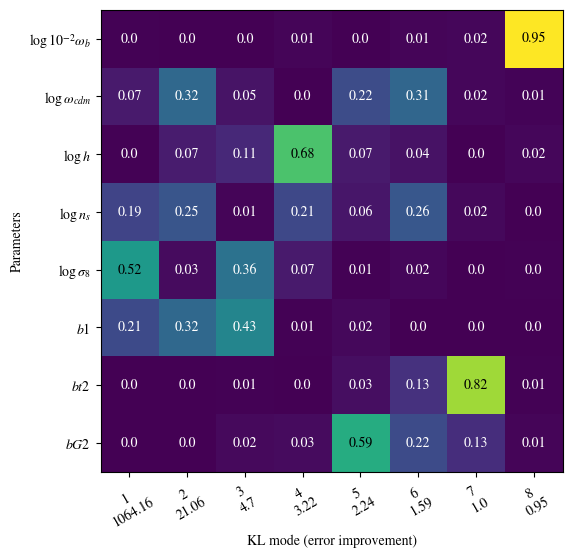

In [25]:
# Do the same on the EC data
KL_eig2, KL_eigv2, KL_param_names2 = plot_frac_fisher(prior_chain=prior2, posterior_chain=posterior2, 
                                                      params=log_params2, labels=log_labels2,
                                                      norm=True, figsize=6, print_improvement=True,
                                                      savename='fisher_cmass_ec.pdf')

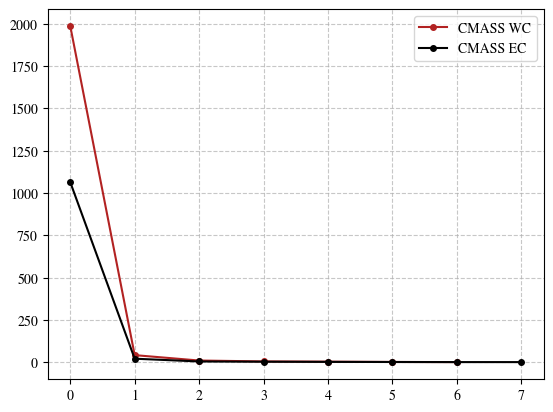

In [26]:
# Plot the scree plot for both datasets: no need to normalize since the eigenvalues are dimensionless
plt.plot(KL_eig1, 'o-', markersize=4, color='firebrick', label='CMASS WC')
plt.plot(KL_eig2, 'o-', markersize=4, color='k', label='CMASS EC')

# Set the legend and the grid
plt.legend()
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.savefig('figures/scree_plot_cmass.pdf', format='pdf', bbox_inches='tight')
plt.show();

<font size=3>

*__Note__: based on the previous scree plot, we add only the first 3 CPC modes since the other ones do not have a noticeable contribution.*

__4.1 Prior Shrinking__

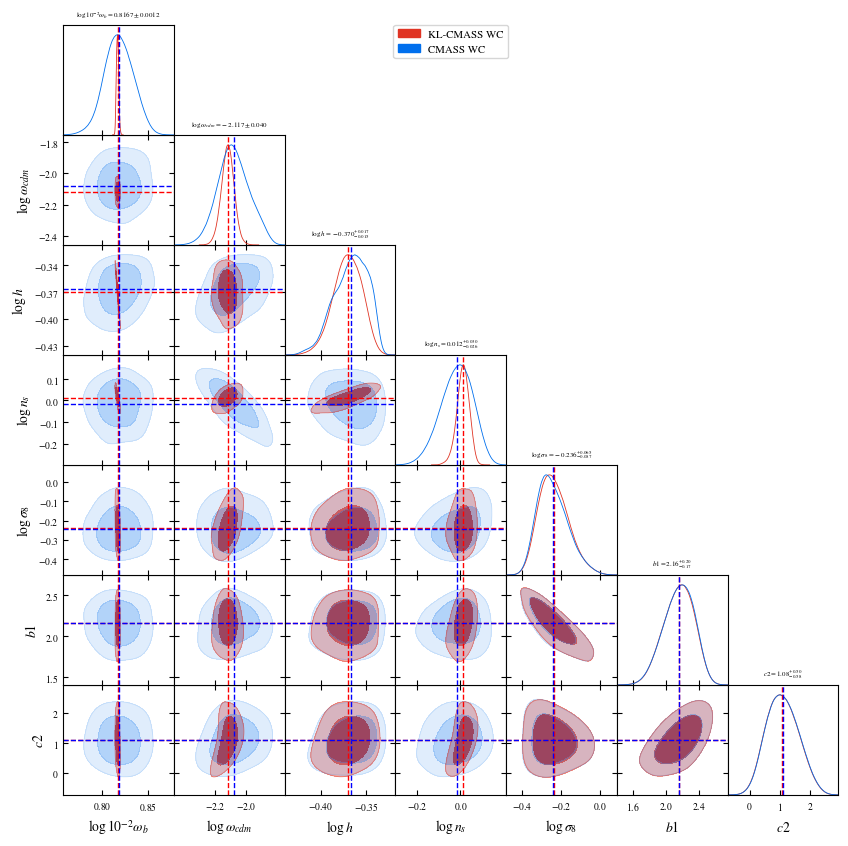

In [29]:
# Push the prior contribution to 0 on the CMASS WC data
idx = [posterior1.index[name] for name in KL_param_names1]
prior_mean = prior1.getMeans(pars=[prior1.index[name] for name in KL_param_names1])
posterior_mean = posterior1.getMeans(pars=[posterior1.index[name] for name in KL_param_names1])
inv_KL_eigv1 = np.linalg.inv(KL_eigv1)
# Only keeping the first 5 modes
inv_KL_eigv1[5:,:] = 0.
# Project the shifted posterior samples on the KL modes
KL_filtered_samples1 = np.dot(np.dot(posterior1.samples[:,idx]-prior_mean, KL_eigv1), inv_KL_eigv1)+prior_mean

# Prior Shrinking - Cosmological Parameters
KL_chain1 = MCSamples(samples=KL_filtered_samples1, 
                     loglikes=posterior1.loglikes, 
                     weights=posterior1.weights, 
                     names=KL_param_names1, 
                     labels=[name.label for name in posterior1.getParamNames().parsWithNames(KL_param_names1)], 
                     label='KL-CMASS WC',
                     settings={'ignore_rows':0.})
g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
g.triangle_plot([KL_chain1, posterior1], params=KL_param_names1, filled=True, title_limit=1)
KL_means1 = KL_chain1.getMeans(pars=[KL_chain1.index[name] for name in KL_param_names1])
means = posterior1.getMeans(pars=[posterior1.index[name] for name in KL_param_names1])
# Display mean indicators
for i in range(len(KL_param_names1)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means1[i], color='red', lw=1., ls='--')
        ax.axvline(means[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means1[i], color='red', lw=1., ls='--')
        ax.axhline(means[i], color='blue', lw=1., ls='--')

plt.savefig('figures/KL_cmass_wc.pdf', format='pdf', bbox_inches='tight')


*Note*: very good overlap on the distributions of $\sigma_8$, $b_1$ and $c_2$.\
On the other hand, the KL-distribution of $\omega_b$ is considerably squeezed by the BBN prior.

In particular $b_1$ and $c_2$ present almost identical distributions: indeed, the priors on these parameters have been left very wide and practically uninformative. However, notice how their variance contribution is not as large as in the BOSS + BBN case.

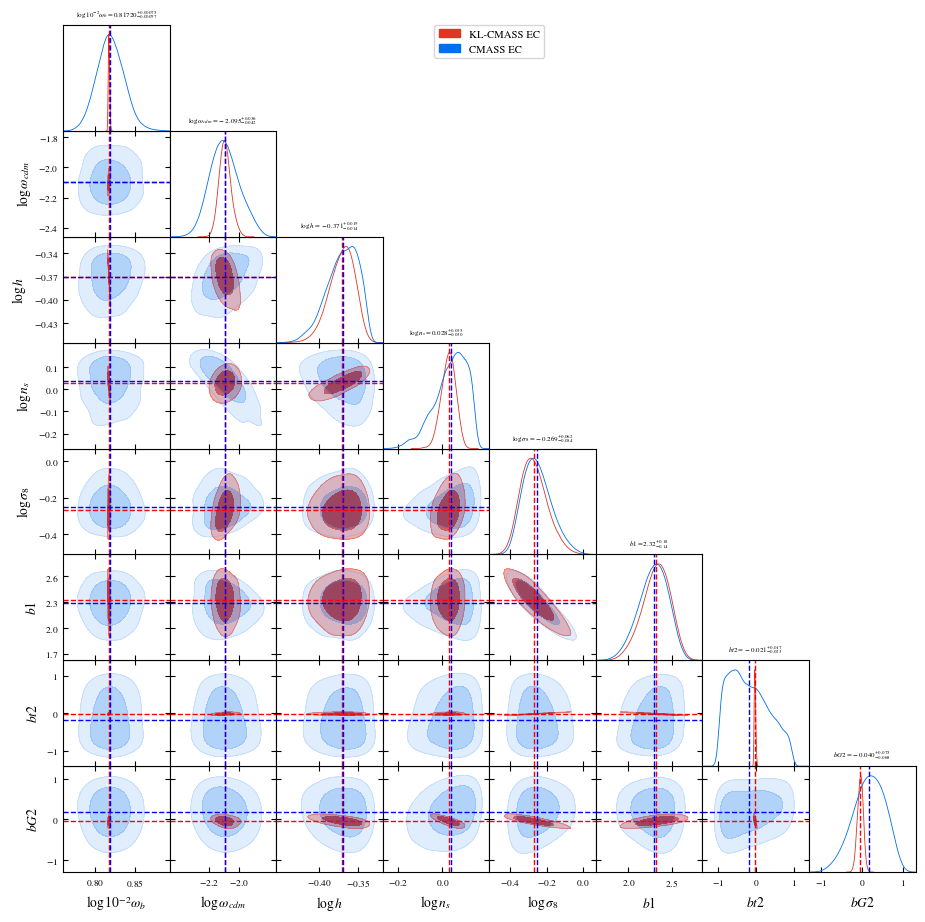

In [30]:
# Push the prior contribution to 0 on the CMASS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean2 = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
posterior_mean2 = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2])
inv_KL_eigv2 = np.linalg.inv(KL_eigv2)
# Only keeping the first 4 modes
inv_KL_eigv2[4:,:] = 0.
# Project the shifted posterior samples on the KL modes
KL_filtered_samples2 = np.dot(np.dot(posterior2.samples[:,idx]-prior_mean2, KL_eigv2), inv_KL_eigv2)+prior_mean2

# Prior Shrinking - Cosmological Parameters
KL_chain2 = MCSamples(samples=KL_filtered_samples2, 
                     loglikes=posterior2.loglikes, 
                     weights=posterior2.weights, 
                     names=KL_param_names2, 
                     labels=[name.label for name in posterior2.getParamNames().parsWithNames(KL_param_names2)], 
                     label='KL-CMASS EC',
                     settings={'ignore_rows':0.})
g = plots.get_subplot_plotter(width_inch=11)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
g.triangle_plot([KL_chain2, posterior2], params=KL_param_names2, filled=True, title_limit=1)
KL_means2 = KL_chain2.getMeans(pars=[KL_chain2.index[name] for name in KL_param_names2])
means2 = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2])
# Display mean indicators
for i in range(len(KL_param_names2)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means2[i], color='red', lw=1., ls='--')
        ax.axvline(means2[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means2[i], color='red', lw=1., ls='--')
        ax.axhline(means2[i], color='blue', lw=1., ls='--')

plt.savefig('figures/KL_cmass_ec.pdf', format='pdf', bbox_inches='tight')

*Note*: good overlap on $h$, $\sigma_8$ and $b_1$.\
$bt_2$ and $bG_2$ seem to be very prior-constrained: no surprise in the small variance contribution on the first modes. This observation justifies the fact that, although this prior setup has one more EFT parameter, $N_{eff}$ is smaller.

__4.2 Prior Explosion__

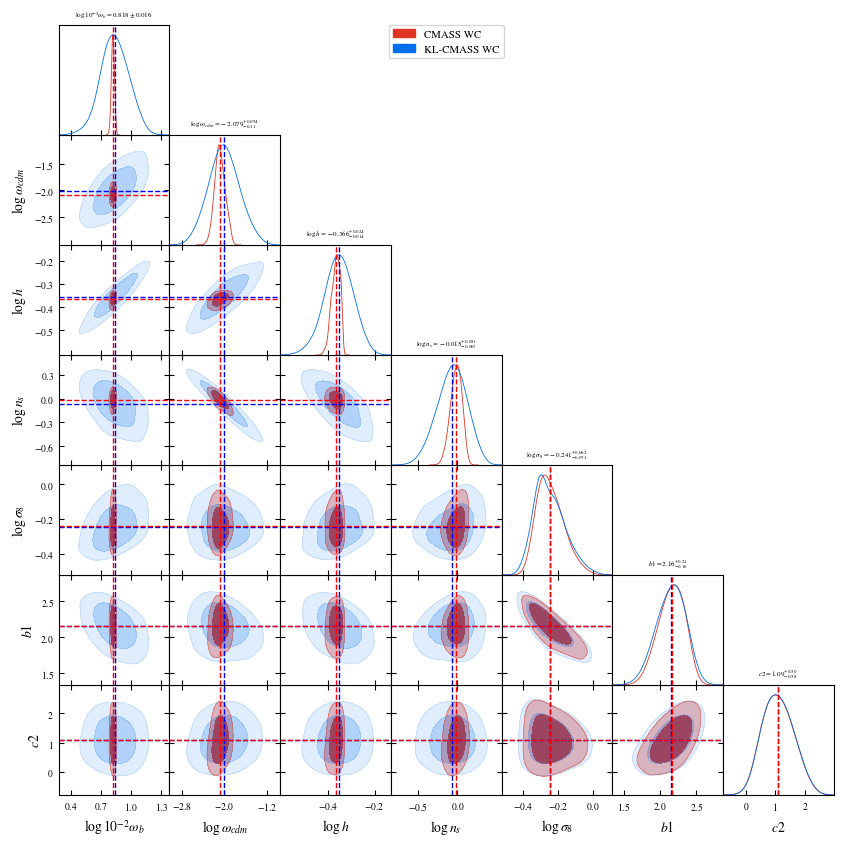

In [31]:
# Push the prior contribution to infinity on the CMASS WC data
idx = [posterior1.index[name] for name in KL_param_names1]
prior_mean = prior1.getMeans(pars=[prior1.index[name] for name in KL_param_names1])
inv_KL_eigv = np.linalg.inv(KL_eigv1)
# Invert the values then send them to 0: this is equivalent to set them to infinity
KL_eig_inv1 = 1./KL_eig1
# Selecting the first 5 modes
KL_eig_inv1[:5] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv1)), 
                                    np.dot(KL_eigv1.T, (posterior1.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv1)*KL_eig_inv1), 
                                                                                          np.dot(KL_eigv1.T, prior_mean)), 
                                    inv_KL_eigv)
# Define the new chain
KL_chain_exp1 = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior1.loglikes, 
                     weights=posterior1.weights, 
                     names=KL_param_names1, 
                     labels=[name.label for name in posterior1.getParamNames().parsWithNames(KL_param_names1)], 
                     label='KL-CMASS WC',
                     settings={'ignore_rows':0.})

# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior1, KL_chain_exp1], params=KL_param_names1, filled=True, title_limit=1);
KL_means = KL_chain_exp1.getMeans(pars=[KL_chain_exp1.index[name] for name in KL_param_names1])
means = posterior1.getMeans(pars=[posterior1.index[name] for name in KL_param_names1])
# Display mean indicators
for i in range(len(KL_param_names1)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

plt.savefig('figures/KL_exp1_cmass_wc.pdf', format='pdf', bbox_inches='tight')

With the EC setup, by performing the prior explosion on the first 4 modes we get significantly larger and degenerate KL-distributions, indicating a greater weight of the prior on the parameter constraint. Let us try to understand the problem by selecting the components whose prior distribution produces these effects.

*__1. Select the first 4 modes__*: large and degenerate KL-distributions.

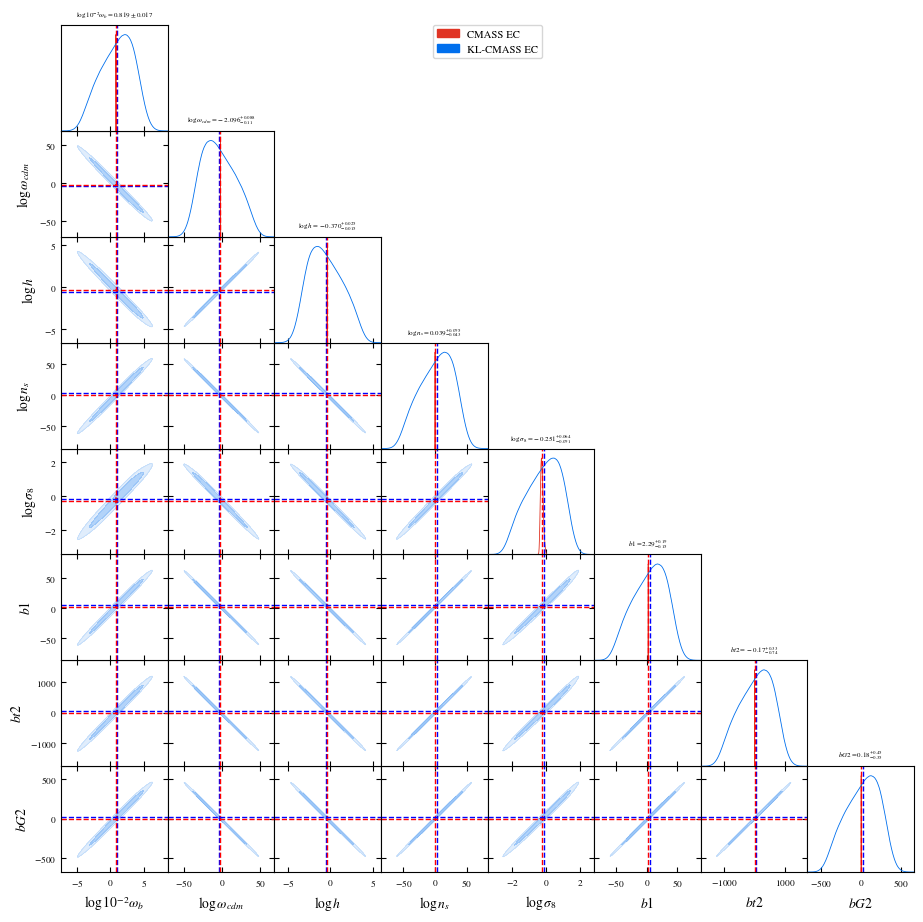

In [33]:
# Push the prior contribution to infinity on the CMASS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
inv_KL_eigv = np.linalg.inv(KL_eigv2)
# Invert the values then send them to 0
KL_eig_inv2 = 1./KL_eig2
# Selecting the first 4 modes
KL_eig_inv2[:4] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv2)), 
                                    np.dot(KL_eigv2.T, 
                                           (posterior2.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv2)*KL_eig_inv2), 
                                                                                          np.dot(KL_eigv2.T, prior_mean)), 
                                            inv_KL_eigv)
# Define the new chain
KL_chain_exp2 = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior2.loglikes, 
                     weights=posterior2.weights, 
                     names=KL_param_names2, 
                     labels=[name.label for name in posterior2.getParamNames().parsWithNames(KL_param_names2)], 
                     label='KL-CMASS EC',
                     settings={'ignore_rows':0.})

# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=11)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior2, KL_chain_exp2], params=KL_param_names2, filled=True, title_limit=1);
KL_means = KL_chain_exp2.getMeans(pars=[KL_chain_exp2.index[name] for name in KL_param_names2])
means = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2])
# Display mean indicators
for i in range(len(KL_param_names2)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

plt.savefig('figures/KL_exp1_cmass_ec.pdf', format='pdf', bbox_inches='tight')

*__1. Select the first 6 modes__*: no significant difference.

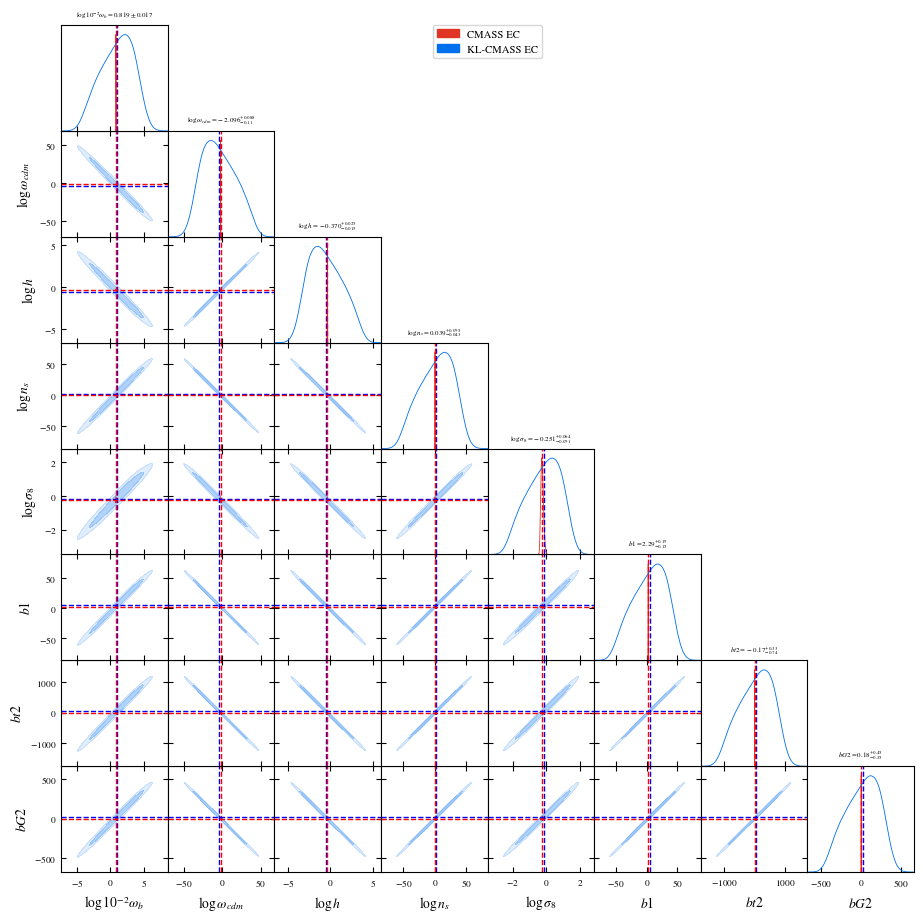

In [34]:
# Push the prior contribution to infinity on the CMASS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
inv_KL_eigv = np.linalg.inv(KL_eigv2)
# Invert the values then send them to 0.
KL_eig_inv2 = 1./KL_eig2
# Selecting the first 6 modes
KL_eig_inv2[:6] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv2)), 
                                    np.dot(KL_eigv2.T, 
                                           (posterior2.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv2)*KL_eig_inv2), 
                                                                                          np.dot(KL_eigv2.T, prior_mean)), 
                                            inv_KL_eigv)
# Define the new chain
KL_chain_exp2 = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior2.loglikes, 
                     weights=posterior2.weights, 
                     names=KL_param_names2, 
                     labels=[name.label for name in posterior2.getParamNames().parsWithNames(KL_param_names2)], 
                     label='KL-CMASS EC',
                     settings={'ignore_rows':0.})

# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=11)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior2, KL_chain_exp2], params=KL_param_names2, filled=True, title_limit=1);
KL_means = KL_chain_exp2.getMeans(pars=[KL_chain_exp2.index[name] for name in KL_param_names2])
means = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2])
# Display mean indicators
for i in range(len(KL_param_names2)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

plt.savefig('figures/KL_exp2_cmass_ec.pdf', format='pdf', bbox_inches='tight')

__*Select the first 7 modes*__: here we include the EFT parameter $bt_2$ and we start to notice some major changes. The distributions are now in better agreement with the results from the prior removal.

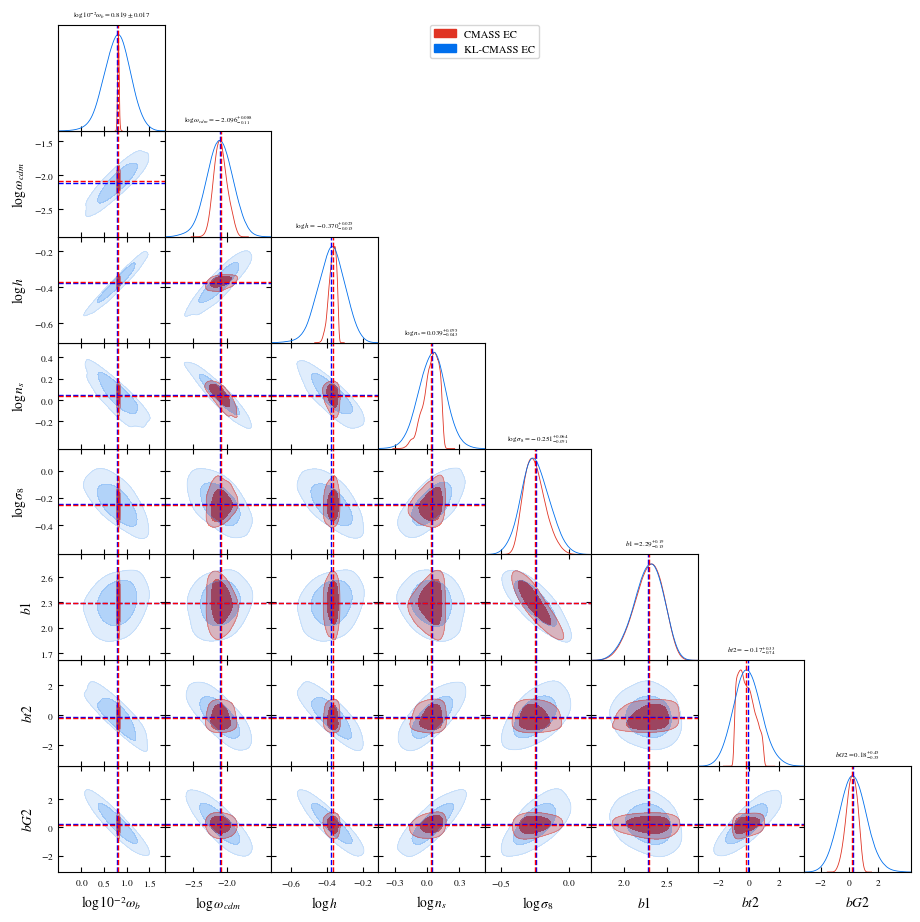

In [35]:
# Push the prior contribution to infinity on the CMASS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
inv_KL_eigv = np.linalg.inv(KL_eigv2)
# Invert the values then send them to 0
KL_eig_inv2 = 1./KL_eig2
# Selecting the first 7 modes
KL_eig_inv2[:7] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv2)), 
                                    np.dot(KL_eigv2.T, 
                                           (posterior2.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv2)*KL_eig_inv2), 
                                                                                          np.dot(KL_eigv2.T, prior_mean)), 
                                            inv_KL_eigv)
# Define the new chain
KL_chain_exp2 = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior2.loglikes, 
                     weights=posterior2.weights, 
                     names=KL_param_names2, 
                     labels=[name.label for name in posterior2.getParamNames().parsWithNames(KL_param_names2)], 
                     label='KL-CMASS EC',
                     settings={'ignore_rows':0.})

# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=11)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior2, KL_chain_exp2], params=KL_param_names2, filled=True, title_limit=1);
KL_means = KL_chain_exp2.getMeans(pars=[KL_chain_exp2.index[name] for name in KL_param_names2])
means = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2])
# Display mean indicators
for i in range(len(KL_param_names2)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

plt.savefig('figures/KL_exp3_cmass_ec.pdf', format='pdf', bbox_inches='tight')

__*Select the seventh mode*__: the result is very similar to the previous case.\
If we look at the CPCA matrix, we realise that the $7^{th}$ mode is mainly informed by $bt_2$. Thus, if we explode the prior contribution of this parameter, the KL-modes are more consistent with the original ones: the prior on $bt_2$ is therefore very informative.

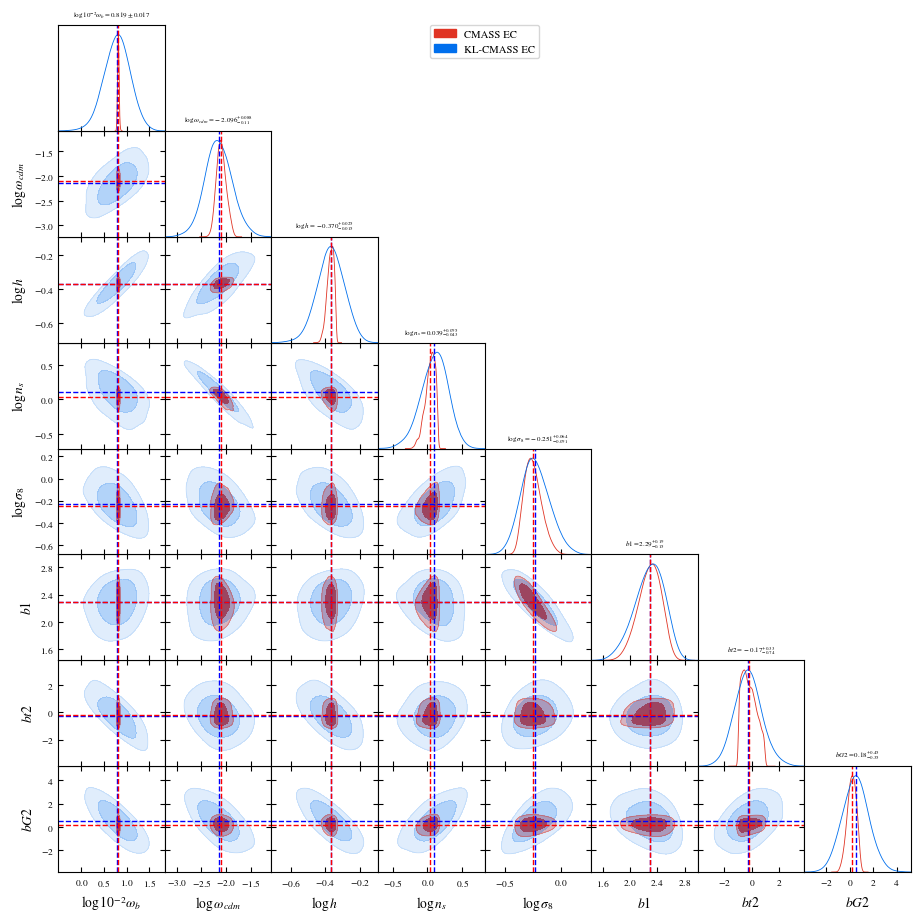

In [36]:
# Push the prior contribution to infinity on the CMASS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
inv_KL_eigv = np.linalg.inv(KL_eigv2)
# Invert the values then send them to 0
KL_eig_inv2 = 1./KL_eig2
# Selecting the seventh mode
KL_eig_inv2[6] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv2)), 
                                    np.dot(KL_eigv2.T, 
                                           (posterior2.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv2)*KL_eig_inv2), 
                                                                                          np.dot(KL_eigv2.T, prior_mean)), 
                                            inv_KL_eigv)
# Define the new chain
KL_chain_exp2 = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior2.loglikes, 
                     weights=posterior2.weights, 
                     names=KL_param_names2, 
                     labels=[name.label for name in posterior2.getParamNames().parsWithNames(KL_param_names2)], 
                     label='KL-CMASS EC',
                     settings={'ignore_rows':0.})

# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=11)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior2, KL_chain_exp2], params=KL_param_names2, filled=True, title_limit=1);
KL_means = KL_chain_exp2.getMeans(pars=[KL_chain_exp2.index[name] for name in KL_param_names2])
means = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2])
# Display mean indicators
for i in range(len(KL_param_names2)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

plt.savefig('figures/KL_exp4_cmass_ec.pdf', format='pdf', bbox_inches='tight')

__4.3 Prior and posterior comparison__\
Here we project the posterior and prior distributions on the KL modes (without removing or exploding the prior contribution): higher similarity between the two distributions means higher prior information level.

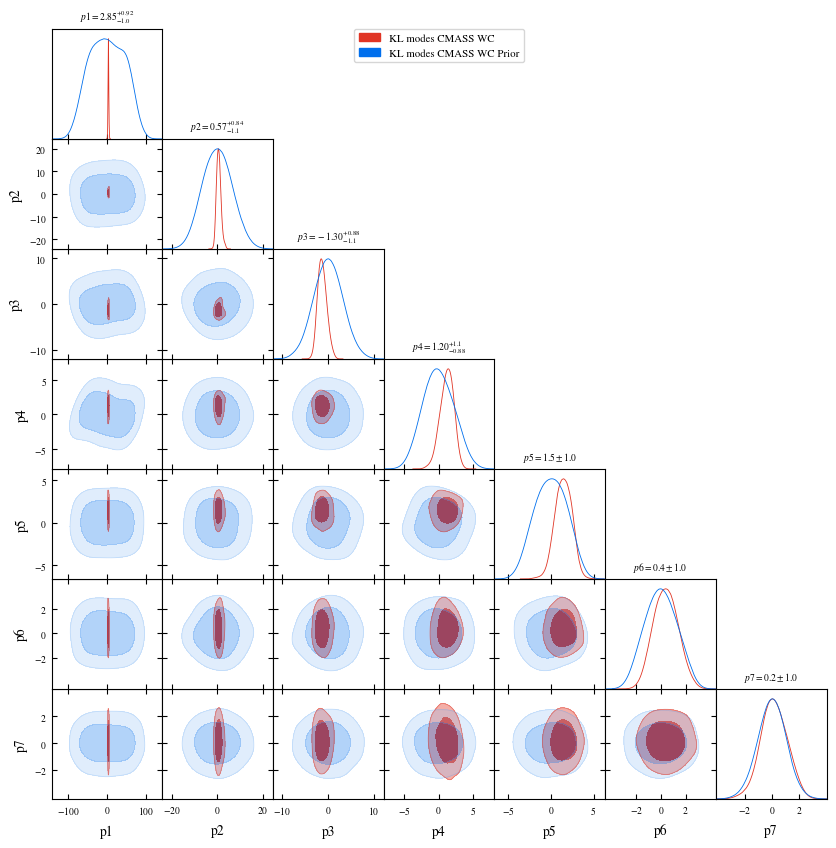

In [37]:
# KL decomposition on the posterior
idx = [posterior1.index[name] for name in KL_param_names1]
prior_mean = prior1.getMeans(pars=[prior1.index[name] for name in KL_param_names1])
temp_names = [f'p{str(i+1)}' for i in range(len(KL_param_names1))]
# Project the shifted posterior samples on the KL modes
KL_filtered_samples = np.dot(posterior1.samples[:,idx] - prior_mean, KL_eigv1)
KL_chain = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior1.loglikes, 
                     weights=posterior1.weights, 
                     names=temp_names, 
                     label='KL modes CMASS WC')
# KL decomposition on the prior
idx = [prior1.index[name] for name in KL_param_names1]
# Project the shifted prior samples on the KL modes
KL_filtered_prior_samples = np.dot(prior1.samples[:,idx] - prior_mean, KL_eigv1)
KL_prior_chain = MCSamples(samples=KL_filtered_prior_samples, 
                     loglikes=prior1.loglikes, 
                     weights=prior1.weights, 
                     names=temp_names, 
                     label='KL modes CMASS WC Prior')
# Plot the KL modes
g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add = 0.3
g.triangle_plot([KL_chain, KL_prior_chain], params=temp_names, 
                filled=True, title_limit=1);

plt.savefig('figures/KL_modes_cmass_wc.pdf', format='pdf', bbox_inches='tight')

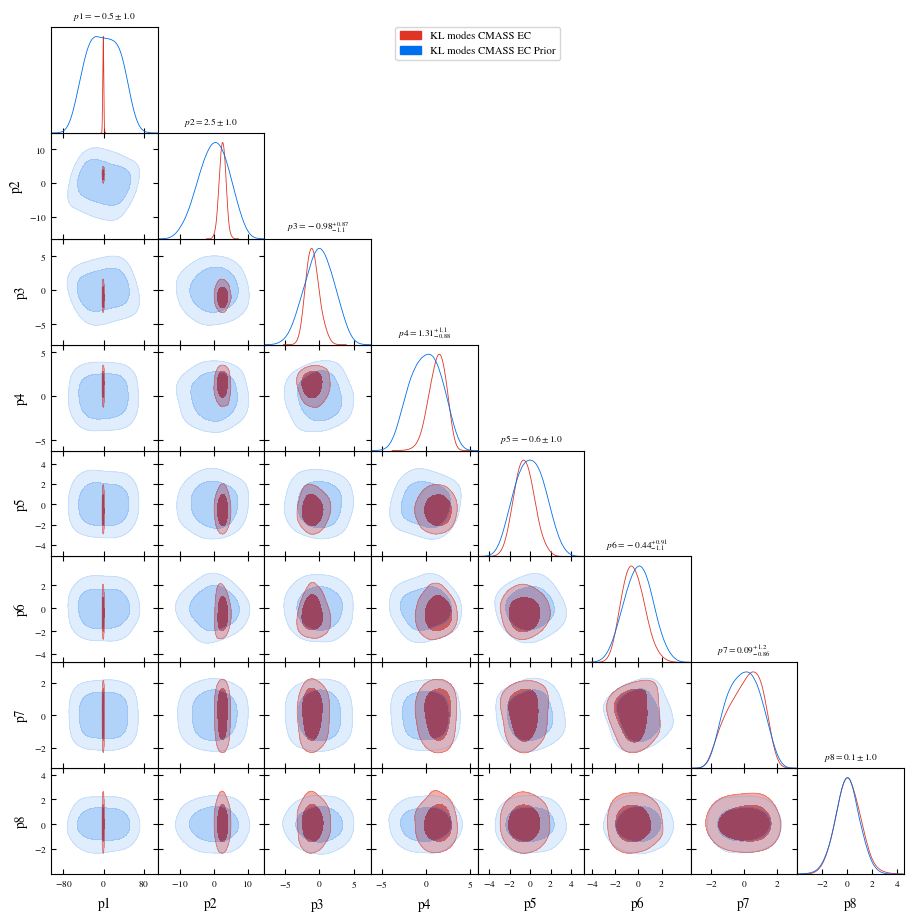

In [38]:
# Repeat the process for the CMASS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
temp_names = [f'p{str(i+1)}' for i in range(len(KL_param_names2))]
# Project the shifted posterior samples on the KL modes
KL_filtered_samples = np.dot(posterior2.samples[:,idx] - prior_mean, KL_eigv2)
KL_chain = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior2.loglikes, 
                     weights=posterior2.weights, 
                     names=temp_names, 
                     label='KL modes CMASS EC')
# KL decomposition on the prior
idx = [prior2.index[name] for name in KL_param_names2]
# Project the shifted prior samples on the KL modes
KL_filtered_prior_samples = np.dot(prior2.samples[:,idx] - prior_mean, KL_eigv2)
KL_prior_chain = MCSamples(samples=KL_filtered_prior_samples, 
                     loglikes=prior2.loglikes, 
                     weights=prior2.weights, 
                     names=temp_names, 
                     label='KL modes CMASS EC Prior')
# Plot the KL modes
g = plots.get_subplot_plotter(width_inch=11)
g.settings.alpha_filled_add = 0.3
g.triangle_plot([KL_chain, KL_prior_chain], params=temp_names, 
                filled=True, title_limit=1);

plt.savefig('figures/KL_modes_cmass_ec.pdf', format='pdf', bbox_inches='tight')

__5. Best-constrained parameters__

In [39]:
from tensiometer_dev.tensiometer import *
# Print CPC parameter combinations
dict1 = gaussian_tension.linear_CPCA_chains(prior1, posterior1, param_names=log_params1)
dict2 = gaussian_tension.linear_CPCA_chains(prior2, posterior2, param_names=log_params2)

# Define the start and end string delimiting the text to be printed
start = 'CPC parameter combinations:'
end = 'CPC modes parameters correlations'
s = gaussian_tension.print_CPCA_results(dict1)
print('CMASS WC CPC Parameter Combinations', end=' ')
print(s[s.find(start)+len(start):s.rfind(end)])
s = gaussian_tension.print_CPCA_results(dict2)
print('\n\nCMASS EC CPC Parameter Combinations', end=' ')
print(s[s.find(start)+len(start):s.rfind(end)])

CMASS WC CPC Parameter Combinations 
   1 : 1985.890 (  4456.3 %)
      -0.70*(\log n_{s } +0.02) +1.00*(\log \sigma_8 +0.24) +0.46*(b1 -2.16) = 0 +- 0.013 (post) / 0.57 (prior)
   2 :   41.155 (   641.5 %)
      +1.00*(\log \omega{}_{cdm } +2.08) +1.30*(\log n_{s } +0.02) +0.03*(b1 -2.16) -0.11*(c2 -1.09) = 0 +- 0.053 (post) / 0.34 (prior)
   3 :    9.229 (   303.8 %)
      -25.44*(\log h +0.37) +1.00*(c2 -1.09) = 0 +- 0.88 (post) / 2.8 (prior)
   4 :    3.972 (   199.3 %)
      +41.83*(\log h +0.37) -19.30*(\log \sigma_8 +0.24) +1.00*(b1 -2.16) = 0 +- 1.8 (post) / 4.1 (prior)
   5 :    2.580 (   160.6 %)
      +1.00*(\log h +0.37) +0.13*(\log n_{s } +0.02) +0.10*(\log \sigma_8 +0.24) = 0 +- 0.022 (post) / 0.042 (prior)
   6 :    0.700 (    83.7 %)
      +1.00*(\log \omega{}_{cdm } +2.08) -2.00*(\log n_{s } +0.02) = 0 +- 0.26 (post) / 0.34 (prior)
   7 :    0.121 (    34.8 %)
      +1.00*(\log 10^{-2}\omega{}_{b } -0.82) = 0 +- 0.016 (post) / 0.017 (prior)




CMASS EC CPC Parameter C

*Note*: $bt_2$ and $bG_2$ do not inform the first $3$ modes.

In [40]:
# Use the first 3 modes to project both datasets. Notice that the first mode is basically equivalent
# Add the derived parameters (new modes) to a copy of the original chain
temp_chain1 = posterior1.copy()
temp_chain2 = posterior2.copy()
p1 = temp_chain1.getParams()
p2 = temp_chain2.getParams()

# Add the new parameters to the first chain
temp_chain1.addDerived(p1.n_s**-0.70 * p1.sigma8**1.00 * np.exp(0.46*p1.b1), 
                            name='p1', label='p_1 = \\frac{\sigma_8 \mathcal{e}^{0.46}}{n_s^{0.70}}')
temp_chain1.addDerived(p1.omega_cdm**1.00 * p1.n_s**1.30 * np.exp(0.03*p1.b1) * np.exp(-0.11*p1.c2),
                            name='p2', label='p_2 = \omega_{cdm} n_s^{1.30} \mathcal{e}^{0.03b_1 - 0.11c_2}')
temp_chain1.addDerived(p1.h**-25.44 * np.exp(p1.c2),
                            name='p3', label='p_3 = \\frac{\mathcal{e}^{c_2}}{h^{25.44}}')

temp_chain2.addDerived(p2.n_s**-0.76 * p2.sigma8**1.00 * np.exp(0.41*p2.b1),
                            name='p1', label='p_1 = \\frac{\sigma_8 \mathcal{e}^{0.41}}{n_s^{0.76}}')
temp_chain2.addDerived(p2.omega_cdm**12.12 * p2.n_s**14.87 * np.exp(p2.b1),
                            name='p2', label='p_2 = \omega_{cdm}^{12.12} n_s^{14.87} \mathcal{e}^{b_1}')
temp_chain2.addDerived(p2.h**38.17 * p2.sigma8**-21.60 * np.exp(p2.b1),
                            name='p3', label='p_3 = \\frac{h^{38.17} \mathcal{e}^{b_1}}{\sigma_8^{21.60}}}')

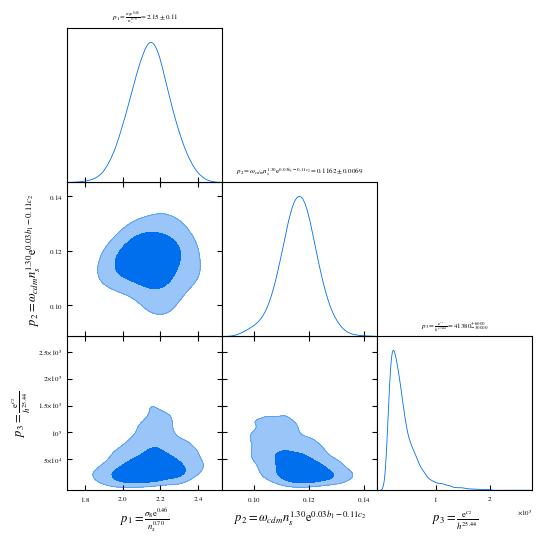

In [41]:
# Plot the new parameters for the first chain
g = plots.get_subplot_plotter(width_inch=6)
g.settings.alpha_filled_add = 0.3
g.settings.axes_labelsize = 12
g.settings.axes_fontsize = 1
g.triangle_plot([temp_chain1], params=['p1', 'p2', 'p3'], filled=True, title_limit=1);

plt.savefig('figures/CPC_cmass_wc.pdf', format='pdf', bbox_inches='tight')

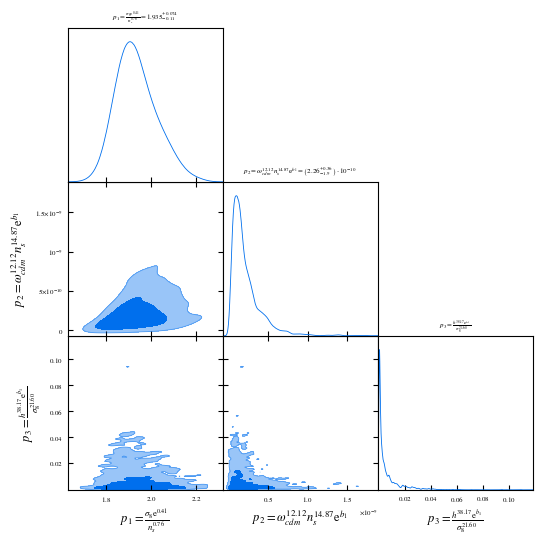

In [46]:
# Plot the new parameters for the second chain
g = plots.get_subplot_plotter(width_inch=6)
g.settings.alpha_filled_add = 0.3
g.settings.axes_labelsize = 12
g.settings.axes_fontsize = 1
g.triangle_plot([temp_chain2], params=['p1', 'p2', 'p3'], filled=True, title_limit=1)

plt.savefig('figures/CPC_cmass_ec.pdf', format='pdf', bbox_inches='tight')

The huge contribution by $h$ and $\sigma_8$ to $p_3$ produces very spiked distributions, and GetDist's automatic bandwidth optimizer fails to display smooth curves.

The common parameters showing a relevant contribution to the first 3 modes are: $\sigma_8$, $n_s$, $\omega_{cdm}$ and $b_1$.

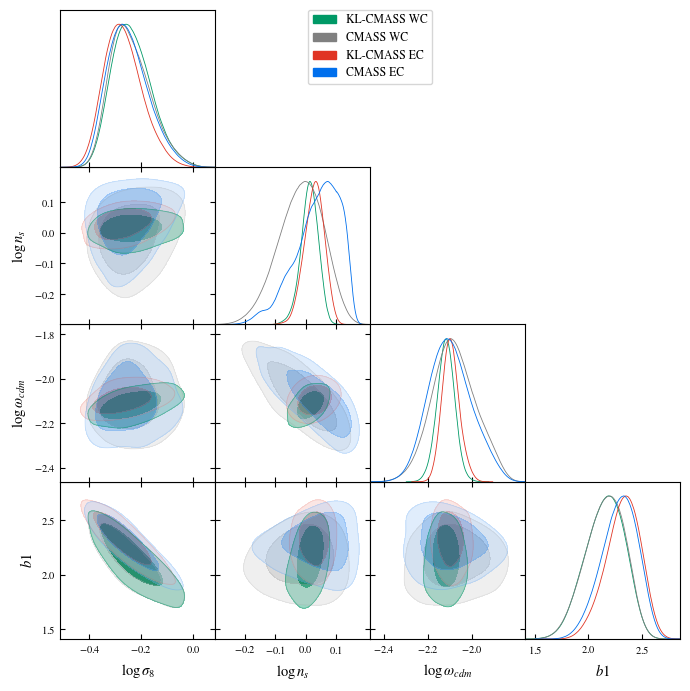

In [43]:
# Graphic evaluation
g = plots.get_subplot_plotter(width_inch=7)
g.settings.alpha_filled_add = 0.3
# Compare the KL-CMASS WC/EC and the CMASS WC/EC distributions for the best-constrained parameters
g.triangle_plot([KL_chain1, posterior1, KL_chain2, posterior2], 
                params=['log_sigma8', 'log_n_s', 'log_omega_cdm', 'b1'], 
                filled=True)

plt.savefig('figures/KL_CMASS_comparison.pdf', format='pdf', bbox_inches='tight')

*Note*: $n_s$ and $b_1$ show a certain discrepancy. The one on $n_s$, however, is mitigated after the prior removal.

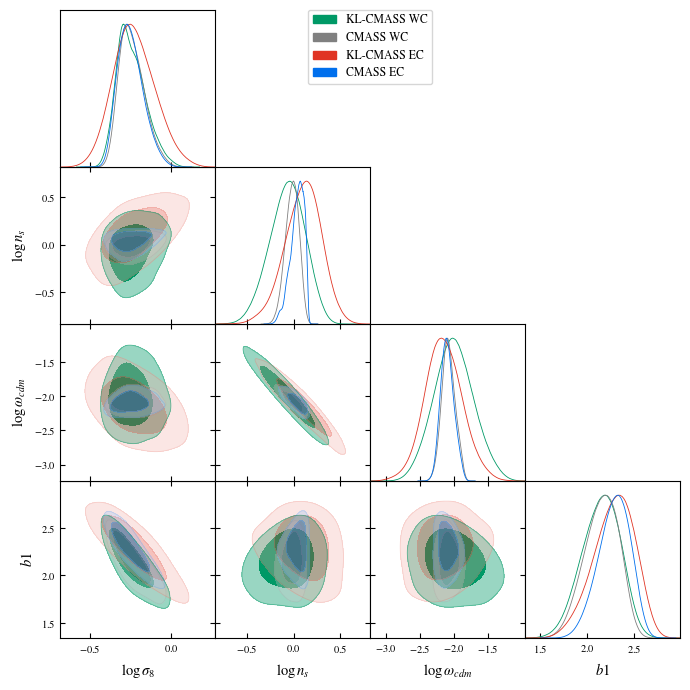

In [44]:
# Graphic evaluation
g = plots.get_subplot_plotter(width_inch=7)
g.settings.alpha_filled_add = 0.3
# Compare the KL-CMASS WC/EC and the CMASS WC/EC distributions for the best-constrained parameters
# Here we use the prior explosion on seventh parameter
g.triangle_plot([KL_chain_exp1, posterior1, KL_chain_exp2, posterior2], 
                params=['log_sigma8', 'log_n_s', 'log_omega_cdm', 'b1'], 
                filled=True)

plt.savefig('figures/KL_exp_CMASS_comparison.pdf', format='pdf', bbox_inches='tight')

*Note*: here the discrepancy is emphasised by the prior explosion and it also generates a difference between the two $\omega_{cdm}$ KL-distributions.

In both cases, $\sigma_8$ distributions are very consistent.

__6. Tension Estimates__

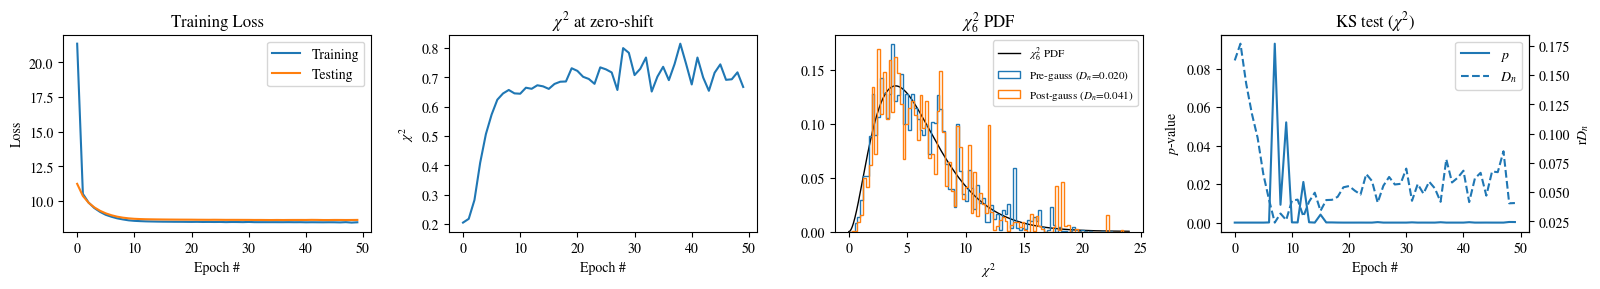

256/256 [==============================] - 10s 38ms/step - loss: 8.4594 - val_loss: 8.6302 - shift0_chi2: 0.6676 - shift0_pval: 0.0048 - shift0_nsigma: 0.0061 - chi2Z_ks: 0.0407 - chi2Z_ks_p: 2.9193e-04 - lr: 0.0010
Training completed.
Time taken to train the model: 529.4007263183594 seconds


In [47]:
from python_scripts.flow import *
# Create a DiffFlow object
flow = DiffFlow(posterior1, posterior2, params=cosmo_params+['b1'], labels=cosmo_labels+['b1'])
# Build the difference chains
flow.build_diff()

# Train the Normalizing Flow model
# Print the time taken to train the model
import time
start = time.time()
flow.train(eta=0.001, epochs=50, batch_size=1024, steps_per_epoch=256)
end = time.time()
print('Time taken to train the model: {} seconds'.format(end-start))

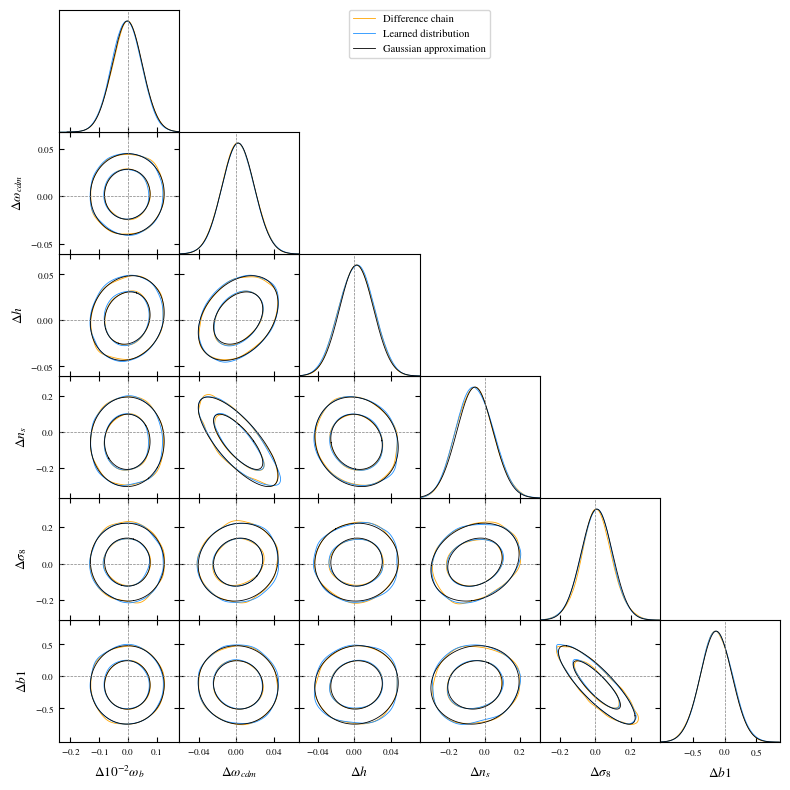

In [48]:
# Plot the learned and the approximated distributions, as well as the difference chain
flow.plot_distributions(savename='/flow_cmass.pdf')

In [49]:
# Print the shift estimate, also in number of sigmas
flow.estimate_shift()

Considering ['delta_omega_b', 'delta_omega_cdm', 'delta_h', 'delta_n_s', 'delta_sigma8', 'delta_b1'] parameters...
Shift probability = 0.00199 + 0.00055 - 0.00044
          n_sigma = 0.002


__7. Result Comparison__

Comparing two best-fit values with asymmetrical associated errors can be more complex than comparing values with symmetrical errors, as the asymmetry needs to be taken into account. Here’s a step-by-step method to compare two such values:

1. **Best-Fit Values and Errors Definition:**
   Let's denote the two best-fit values as $A$ and $B$, with their respective errors:
   - $A$ with lower error $\sigma_{A-}$ and upper error $\sigma_{A+}$
   - $B$ with lower error $\sigma_{B-}$ and upper error $\sigma_{B+}$

2. **Calculate the Difference:**
   Compute the difference between the two best-fit values:
   $$
   \Delta = A - B
   $$

3. **Estimate the Combined Errors:**
   To compare the two values, we need to estimate the error in the difference $\Delta$. This can be complex due to the asymmetrical nature of the errors, but a simplified approach involves estimating the combined error as follows:

   - Lower combined error ($\sigma_{\Delta-}$):
     $$
     \sigma_{\Delta-} = \sqrt{\sigma_{A-}^2 + \sigma_{B+}^2}
     $$
   - Upper combined error ($\sigma_{\Delta+}$):
     $$
     \sigma_{\Delta+} = \sqrt{\sigma_{A+}^2 + \sigma_{B-}^2}
     $$

4. **Determine the Significance of the Difference:**
   Assess whether the difference $\Delta$ is significant by comparing it to the combined errors. Specifically, calculate the significance in terms of standard deviations (or z-scores).

   - For the lower error (if $\Delta$ is negative):
     $$
     z_{-} = \frac{\Delta}{\sigma_{\Delta-}}
     $$
   - For the upper error (if $\Delta$ is positive):
     $$
     z_{+} = \frac{\Delta}{\sigma_{\Delta+}}
     $$

   Alternatively, if you want a single significance metric, you can average the significance contributions from the lower and upper errors:

   $$
   z_{\text{avg}} = \frac{|\Delta|}{\sqrt{\left(\frac{\sigma_{\Delta-} + \sigma_{\Delta+}}{2}\right)^2}}
   $$

5. **Interpret the Results:**
   - If $z_{-}$ or $z_{+}$ is greater than a typical threshold (e.g., 1.96 for a 95% confidence level), the difference can be considered statistically significant.
   - The actual significance level can be converted into a p-value if needed.

#### Example Calculation

Let's go through an example:

- Best-fit value $A = 5.0$ with errors $\sigma_{A-} = 0.3$ and $\sigma_{A+} = 0.5$
- Best-fit value $B = 4.5$ with errors $\sigma_{B-} = 0.4$ and $\sigma_{B+} = 0.2$

1. Calculate the difference:
   $$
   \Delta = 5.0 - 4.5 = 0.5
   $$

2. Estimate the combined errors:
   $$
   \sigma_{\Delta-} = \sqrt{0.3^2 + 0.2^2} = \sqrt{0.09 + 0.04} = \sqrt{0.13} \approx 0.36
   $$
   $$
   \sigma_{\Delta+} = \sqrt{0.5^2 + 0.4^2} = \sqrt{0.25 + 0.16} = \sqrt{0.41} \approx 0.64
   $$

3. Calculate the significance:
   - If $\Delta$ is positive:
     $$
     z_{+} = \frac{0.5}{0.64} \approx 0.78
     $$

   The $z$-score of 0.78 indicates that the difference is not statistically significant at a typical confidence level (e.g., 95% confidence level requires a $z$-score of approximately 1.96).

This method provides a way to compare two values with asymmetrical errors, considering both lower and upper errors in the analysis.

In [211]:
# Function to get the best-fit values
def get_best_fit(posterior=None, params=None):
    # Get the best-fit values as a Latex string array
    best_fit = posterior.getLatex(params=params)[1]
    # Get the means
    means = posterior.getMeans(pars=[posterior.index[name] for name in params])
    # Initialize the lower and upper bounds
    lower = np.zeros(len(params))
    upper = np.zeros(len(params))
    # Get the lower and upper bounds
    for i in range(len(params)):
        # If there is the \pm symbol in the string, we have just one value
        if '\pm' in best_fit[i]:
            # Get the value
            upper[i] = float(best_fit[i].split(' ')[1])
            lower[i] = -float(best_fit[i].split(' ')[1])
        else:
            # The lower bound is the first value inside the {} brackets
            upper[i] = float(best_fit[i].split('{')[1].split('}')[0])
            # The upper bound is the second value inside the {} brackets
            lower[i] = float(best_fit[i].split('{')[2].split('}')[0])

    # Put the means, the lower and upper values inside a DataFrame
    return pd.DataFrame(data={'Mean':means, 'Lower':np.abs(lower), 'Upper':upper}, index=params)

In [212]:
# Compare the results using the procedure described above
df_best_fit1 = get_best_fit(posterior1, KL_param_names1[:-1])
df_best_fit2 = get_best_fit(posterior2, KL_param_names1[:-1])
# Concatenate the two DataFrames
df_best_fit = pd.concat([df_best_fit1, df_best_fit2], axis=1)
# Rename the columns
df_best_fit.columns = ['WC '+ col for col in df_best_fit.columns[:3]]+['EC '+ col for col in df_best_fit.columns[3:]]
# Compute the difference and the errors
df_best_fit['Delta'] = abs(df_best_fit['WC Mean'] - df_best_fit['EC Mean'])
df_best_fit['sigma-'] = np.sqrt(df_best_fit['WC Lower']**2 + df_best_fit['EC Lower']**2)
df_best_fit['sigma+'] = np.sqrt(df_best_fit['WC Upper']**2 + df_best_fit['EC Upper']**2)
# Divide by the sum of the errors
df_best_fit['z-'] = df_best_fit['Delta']/df_best_fit['sigma-']
df_best_fit['z+'] = df_best_fit['Delta']/df_best_fit['sigma+']
df_best_fit['z_avg'] = df_best_fit['Delta']/(np.sqrt((0.5*(df_best_fit['sigma-']+df_best_fit['sigma+'])**2)))

In [213]:
df_best_fit

,WC Mean,WC Lower,WC Upper,EC Mean,EC Lower,EC Upper,Delta,sigma-,sigma+,z-,z+,z_avg
log_omega_b,0.818132,0.016,0.016,0.819113,0.017,0.017,0.000981,0.023345,0.023345,0.042022,0.042022,0.029714
log_omega_cdm,-2.078952,0.110,0.094,-2.096238,0.110,0.088,0.017286,0.155563,0.128763,0.111116,0.134243,0.085977
log_h,-0.366279,0.014,0.024,-0.370061,0.015,0.025,0.003782,0.020518,0.034655,0.184301,0.109118,0.096928
log_n_s,-0.015351,0.067,0.081,0.038984,0.043,0.095,0.054335,0.079612,0.124844,0.682499,0.435222,0.375833
log_sigma8,-0.241287,0.091,0.062,-0.250798,0.091,0.064,0.009511,0.128693,0.089107,0.073908,0.106742,0.061759
b1,2.157714,0.160,0.210,2.290654,0.150,0.190,0.132940,0.219317,0.283196,0.606154,0.469427,0.374131


In [214]:
# Repeat the process for the KL chains
df_best_fit1 = get_best_fit(KL_chain1, KL_param_names1[:-1])
df_best_fit2 = get_best_fit(KL_chain2, KL_param_names1[:-1])
# Concatenate the two DataFrames
df_best_fit = pd.concat([df_best_fit1, df_best_fit2], axis=1)
# Rename the columns
df_best_fit.columns = ['WC '+ col for col in df_best_fit.columns[:3]]+['EC '+ col for col in df_best_fit.columns[3:]]
# Compute the difference and the errors
df_best_fit['Delta'] = abs(df_best_fit['WC Mean'] - df_best_fit['EC Mean'])
df_best_fit['sigma-'] = np.sqrt(df_best_fit['WC Lower']**2 + df_best_fit['EC Lower']**2)
df_best_fit['sigma+'] = np.sqrt(df_best_fit['WC Upper']**2 + df_best_fit['EC Upper']**2)
# Divide by the sum of the errors
df_best_fit['z-'] = df_best_fit['Delta']/df_best_fit['sigma-']
df_best_fit['z+'] = df_best_fit['Delta']/df_best_fit['sigma+']
df_best_fit['z_avg'] = df_best_fit['Delta']/(np.sqrt((0.5*(df_best_fit['sigma-']+df_best_fit['sigma+'])**2)))

In [215]:
df_best_fit

,WC Mean,WC Lower,WC Upper,EC Mean,EC Lower,EC Upper,Delta,sigma-,sigma+,z-,z+,z_avg
log_omega_b,0.816713,0.0012,0.0012,0.817204,0.00097,0.00075,0.000491,0.001543,0.001415,0.318237,0.347004,0.234758
log_omega_cdm,-2.117021,0.0400,0.0400,-2.094636,0.04200,0.03600,0.022385,0.058000,0.053814,0.385950,0.415967,0.283123
log_h,-0.370209,0.0150,0.0170,-0.370958,0.01400,0.01900,0.000748,0.020518,0.025495,0.036473,0.029354,0.023001
log_n_s,0.012222,0.0260,0.0300,0.027646,0.03000,0.03500,0.015425,0.039699,0.046098,0.388542,0.334608,0.254250
log_sigma8,-0.236072,0.0870,0.0650,-0.268548,0.08400,0.06200,0.032476,0.120934,0.089828,0.268547,0.361542,0.217918
b1,2.155474,0.1700,0.2000,2.323796,0.14000,0.18000,0.168322,0.220227,0.269072,0.764310,0.625563,0.486497


In [226]:
# Compare the results using the Confidence Interval Overlap
df_best_fit1 = get_best_fit(posterior1, KL_param_names1[:-1])
df_best_fit2 = get_best_fit(posterior2, KL_param_names1[:-1])
# Concatenate the two DataFrames
df_best_fit = pd.concat([df_best_fit1, df_best_fit2], axis=1)
# Rename the columns
df_best_fit.columns = ['WC '+ col for col in df_best_fit.columns[:3]]+['EC '+ col for col in df_best_fit.columns[3:]]
# Compute the difference and the errors
df_best_fit['Delta'] = abs(df_best_fit['WC Mean'] - df_best_fit['EC Mean'])
# Compute the percentage difference
df_best_fit['Delta %'] = 100.*df_best_fit['Delta']/np.sqrt(df_best_fit['WC Mean']**2 + df_best_fit['EC Mean']**2)
# Compute the percentage overlap
wc_lower = df_best_fit['WC Mean'] - df_best_fit['WC Lower']
wc_upper = df_best_fit['WC Upper'] + df_best_fit['WC Mean']
ec_lower = df_best_fit['EC Mean'] - df_best_fit['EC Lower']
ec_upper = df_best_fit['EC Upper'] + df_best_fit['EC Mean']
for i in range(len(df_best_fit)):
    df_best_fit.loc[df_best_fit.index[i], 'Overlap'] = np.max([0, np.min([wc_upper[i], ec_upper[i]]) - np.max([wc_lower[i], ec_lower[i]])])
# Compute the percentage overlap, using only 3 numbers after the comma
df_best_fit['WC Overlap %'] = (100.*(df_best_fit['Overlap']/(wc_upper - wc_lower))).round(3)
df_best_fit['EC Overlap %'] = (100.*(df_best_fit['Overlap']/(ec_upper - ec_lower))).round(3)

In [227]:
df_best_fit

,WC Mean,WC Lower,WC Upper,EC Mean,EC Lower,EC Upper,Delta,Delta %,Overlap,WC Overlap %,EC Overlap %
log_omega_b,0.818132,0.016,0.016,0.819113,0.017,0.017,0.000981,0.084738,0.032000,100.000,94.118
log_omega_cdm,-2.078952,0.110,0.094,-2.096238,0.110,0.088,0.017286,0.585491,0.180714,88.585,91.270
log_h,-0.366279,0.014,0.024,-0.370061,0.015,0.025,0.003782,0.726272,0.035218,92.680,88.046
log_n_s,-0.015351,0.067,0.081,0.038984,0.043,0.095,0.054335,129.685771,0.069665,47.071,50.482
log_sigma8,-0.241287,0.091,0.062,-0.250798,0.091,0.064,0.009511,2.733001,0.145489,95.091,93.864
b1,2.157714,0.160,0.210,2.290654,0.150,0.190,0.132940,4.224507,0.227060,61.368,66.782


In [228]:
# Repeat the process for the KL chains
df_best_fit1 = get_best_fit(KL_chain1, KL_param_names1[:-1])
df_best_fit2 = get_best_fit(KL_chain2, KL_param_names1[:-1])
# Concatenate the two DataFrames
df_best_fit = pd.concat([df_best_fit1, df_best_fit2], axis=1)
# Rename the columns
df_best_fit.columns = ['WC '+ col for col in df_best_fit.columns[:3]]+['EC '+ col for col in df_best_fit.columns[3:]]
# Compute the difference and the errors
df_best_fit['Delta'] = abs(df_best_fit['WC Mean'] - df_best_fit['EC Mean'])
# Compute the percentage difference
df_best_fit['Delta %'] = 100.*df_best_fit['Delta']/np.sqrt(df_best_fit['WC Mean']**2 + df_best_fit['EC Mean']**2)
# Compute the percentage overlap
wc_lower = df_best_fit['WC Mean'] - df_best_fit['WC Lower']
wc_upper = df_best_fit['WC Upper'] + df_best_fit['WC Mean']
ec_lower = df_best_fit['EC Mean'] - df_best_fit['EC Lower']
ec_upper = df_best_fit['EC Upper'] + df_best_fit['EC Mean']
for i in range(len(df_best_fit)):
    df_best_fit.loc[df_best_fit.index[i], 'Overlap'] = np.max([0, np.min([wc_upper[i], ec_upper[i]]) - np.max([wc_lower[i], ec_lower[i]])])
# Compute the percentage overlap, using only 3 numbers after the comma
df_best_fit['WC Overlap %'] = (100.*(df_best_fit['Overlap']/(wc_upper - wc_lower))).round(3)
df_best_fit['EC Overlap %'] = (100.*(df_best_fit['Overlap']/(ec_upper - ec_lower))).round(3)

In [229]:
df_best_fit

,WC Mean,WC Lower,WC Upper,EC Mean,EC Lower,EC Upper,Delta,Delta %,Overlap,WC Overlap %,EC Overlap %
log_omega_b,0.816713,0.0012,0.0012,0.817204,0.00097,0.00075,0.000491,0.042502,0.001679,69.956,97.614
log_omega_cdm,-2.117021,0.0400,0.0400,-2.094636,0.04200,0.03600,0.022385,0.751648,0.059615,74.519,76.429
log_h,-0.370209,0.0150,0.0170,-0.370958,0.01400,0.01900,0.000748,0.142796,0.031748,99.214,96.207
log_n_s,0.012222,0.0260,0.0300,0.027646,0.03000,0.03500,0.015425,51.028878,0.044575,79.599,68.577
log_sigma8,-0.236072,0.0870,0.0650,-0.268548,0.08400,0.06200,0.032476,9.082844,0.116524,76.660,79.811
b1,2.155474,0.1700,0.2000,2.323796,0.14000,0.18000,0.168322,5.310579,0.171678,46.399,53.649


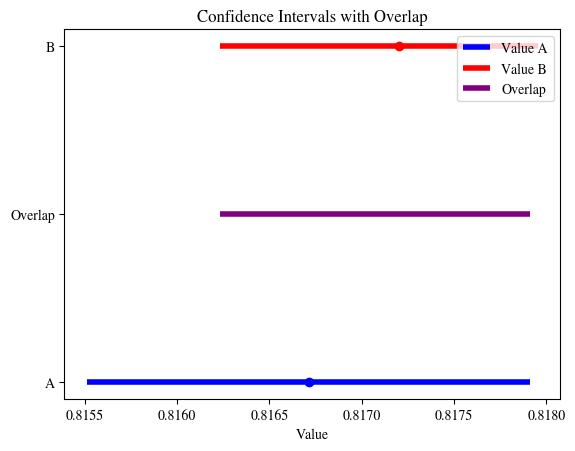

In [232]:
A_lower = (df_best_fit['WC Mean'] - df_best_fit['WC Lower'])[0]
A_upper = (df_best_fit['WC Mean'] + df_best_fit['WC Upper'])[0]
B_lower = (df_best_fit['EC Mean'] - df_best_fit['EC Lower'])[0]
B_upper = (df_best_fit['EC Mean'] + df_best_fit['EC Upper'])[0]

A = df_best_fit['WC Mean'][0]
B = df_best_fit['EC Mean'][0]

overlap_lower = max(A_lower, B_lower)
overlap_upper = min(A_upper, B_upper)
overlap_exists = overlap_lower < overlap_upper

# Plot the confidence intervals
fig, ax = plt.subplots()

# Plot A's confidence interval
ax.hlines(1, A_lower, A_upper, colors='blue', lw=4, label='Value A')
ax.plot(A, 1, 'bo')

# Plot B's confidence interval
ax.hlines(2, B_lower, B_upper, colors='red', lw=4, label='Value B')
ax.plot(B, 2, 'ro')

# Plot the overlapping region if it exists
if overlap_exists:
    ax.hlines(1.5, overlap_lower, overlap_upper, colors='purple', lw=4, label='Overlap')

# Draw lines at the ends of the confidence intervals
ax.hlines(1, A_lower, A_lower, colors='blue', lw=1)
ax.hlines(1, A_upper, A_upper, colors='blue', lw=1)
ax.hlines(2, B_lower, B_lower, colors='red', lw=1)
ax.hlines(2, B_upper, B_upper, colors='red', lw=1)

# Customize the plot
ax.set_yticks([1, 1.5, 2])
ax.set_yticklabels(['A', 'Overlap', 'B'])
ax.set_xlabel('Value')
ax.set_title('Confidence Intervals with Overlap')
ax.legend()

plt.show()